# Explore UniProt keywords

url: https://www.uniprot.org/uniprotkb?facets=reviewed%3Atrue&query=%28taxonomy_id%3A9606%29
1. Select the following columns:
Entry	Entry Name	Protein Names	Gene Names	Organism	Keywords HGNC

2. Select Reviewed only (~20,500)

In [1]:
from collections import Counter

import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it

import os.path as osp
import json

Below, I downloaded the [UniProt table for human proteins](https://www.uniprot.org/uniprotkb?query=%28Human%29). I added on Keywords and HGNC as columns:

In [2]:
MAPPING_DIR = '../data/mappings/'

In [3]:
# Release 2022_05
uniprot = pd.read_csv(
    osp.join(MAPPING_DIR, 'uniprotkb_Human_AND_reviewed_true_2023_10_05.tsv.gz'),
    sep='\t',
    compression='gzip',
    usecols=[
        'Keywords',
        'Entry',
    ]
)

In [4]:
uniprot.head(10)

,Entry,Keywords
0,A0A024B7W1,3D-structure;4Fe-4S;Activation of host autopha...
1,A0A068B6Q6,3D-structure;Acetylcholine receptor inhibiting...
2,A0A076FFM5,2Fe-2S;Chloroplast;Cytoplasm;Iron;Iron-sulfur;...
3,A0A087X1C5,Cytoplasm;Glycoprotein;Heme;Iron;Membrane;Meta...
4,A0A0A1I6E7,Amidation;Antibiotic;Antimicrobial;Cleavage on...
5,A0A0A1I6N9,Amidation;Antibiotic;Antimicrobial;Cleavage on...
6,A0A0B4J2F0,Direct protein sequencing;Membrane;Mitochondri...
7,A0A0B4J2F2,ATP-binding;Kinase;Magnesium;Metal-binding;Nuc...
8,A0A0B4KGY6,Alternative splicing;Cytoplasm;mRNA processing...
9,A0A0B4U9L8,Calcium;Cell adhesion impairing toxin;Direct p...


Get our KG and all the protein nodes inside. We are getting the KG which includes the test set:

In [5]:
KG_DIR = '../data/kg'

In [6]:
kg = pd.read_csv(osp.join(KG_DIR, 'final_kg.tsv'), sep='\t')

Get the proteins:

In [7]:
target_sets = set(kg[kg['target'].str.startswith('ncbigene')]['target'].tolist())
source_sets = set(kg[kg['source'].str.startswith('ncbigene')]['source'].tolist())
proteins_in_kg = target_sets.union(source_sets)
len(proteins_in_kg)

9301

Next, let's get a mapping from UniProt to NCBI gene ID:

In [8]:
with open(osp.join(MAPPING_DIR, 'uniprot2ncbi.json')) as f:
    uniprot2ncbi = json.load(f)

Get the valid protein classes:

In [9]:
valid_keywords = pd.read_csv(
    osp.join(MAPPING_DIR, 'molecular_function.tsv'),
    sep='\t',
)

In [10]:
valid_keywords

,Keyword ID,Name,Category,Gene Ontologies
0,KW-0008,Acetylcholine receptor inhibiting toxin,Molecular function,GO:0030550:acetylcholine receptor inhibitor ac...
1,KW-0009,Actin-binding,Molecular function,GO:0003779:actin binding
2,KW-0010,Activator,Molecular function,NaN
3,KW-0012,Acyltransferase,Molecular function,GO:0016746:acyltransferase activity
4,KW-0021,Allosteric enzyme,Molecular function,"GO:0003824:catalytic activity, GO:0008152:meta..."
...,...,...,...,...
193,KW-1244,Viral short tail ejection system,Molecular function,GO:0099002:viral genome ejection through host ...
194,KW-1255,Viral exotoxin,Molecular function,NaN
195,KW-1265,Chloride channel impairing toxin,Molecular function,NaN
196,KW-1275,Proton-gated sodium channel impairing toxin,Molecular function,NaN


In [11]:
molecular_functions = valid_keywords.Name.unique()

Now, we'll make a dictionary mapping each of our KG proteins to their protein class (or keywords):

In [12]:
all_keywords = []

not_mapped = 0
no_keywords = 0

protein_to_keywords = {}

for prot_name, keywords in tqdm(uniprot.values):
    # Map from UniProt to NCBI
    if 'UniProt:' + str(prot_name) not in uniprot2ncbi:
        not_mapped += 1
        continue
    
    """Get keywords"""
    protein_keywords = set()
    
    for keyword in keywords.split(';'):
        
        if keyword not in molecular_functions:
            continue
        
        protein_keywords.add(keyword.strip())
        all_keywords.append(keyword.strip())
        
    if not protein_keywords:
        no_keywords += 1
        continue
        
    protein_to_keywords[uniprot2ncbi['UniProt:' + str(prot_name)]] = protein_keywords

100%|██████████| 51790/51790 [00:01<00:00, 27061.65it/s]


In [13]:
len(protein_to_keywords), no_keywords, not_mapped, len(set(all_keywords))

(11220, 8880, 31690, 130)

Which keywords are most common? 

In [14]:
valid_keywords = [
    k
    for k, c in Counter(all_keywords).items()
    if c > 50
]

In [15]:
len(valid_keywords)

61

Removing superclasses and keywords with a few proteins

In [16]:
protein_to_keywords = {
    protein: {
        keyword
        for keyword in keywords
        if keyword in valid_keywords and keyword not in [
            'Transducer',
            'Serine/threonine-protein kinase',
            'Activator',
        ]
    }
    for protein, keywords in protein_to_keywords.items()
}

Map the proteins in our KG to Uniprot keywords:

In [17]:
nodes2keywords = {key: val for key, val in protein_to_keywords.items() if key in proteins_in_kg and len(val) > 0}

Those which map to classes:

In [18]:
len(nodes2keywords)

6378

Those which don't:

In [19]:
len(proteins_in_kg) - len(nodes2keywords)

2923

In [20]:
2769 / (1268+2769)

0.6859053752786722

Get some further stats:

In [21]:
keywords_in_nodes = list()
number_of_keywords = dict()
for key, val in nodes2keywords.items():
    keywords_in_nodes.extend(list(val))
    number_of_keywords[key] = len(val)

Let's see the most popular classes:

In [22]:
most_popular = Counter(keywords_in_nodes)
most_popular.most_common()

[('Transferase', 1190),
 ('Receptor', 1188),
 ('DNA-binding', 1071),
 ('Hydrolase', 948),
 ('G-protein coupled receptor', 681),
 ('Developmental protein', 498),
 ('Kinase', 483),
 ('Oxidoreductase', 393),
 ('RNA-binding', 387),
 ('Repressor', 341),
 ('Ion channel', 234),
 ('Protease', 232),
 ('Ribonucleoprotein', 206),
 ('Chromatin regulator', 170),
 ('Cytokine', 167),
 ('Glycosyltransferase', 155),
 ('Actin-binding', 133),
 ('Lyase', 129),
 ('Ribosomal protein', 124),
 ('Calmodulin-binding', 115),
 ('Growth factor', 109),
 ('Chaperone', 107),
 ('GTPase activation', 98),
 ('Voltage-gated channel', 95),
 ('Tyrosine-protein kinase', 95),
 ('Acyltransferase', 92),
 ('Ligase', 86),
 ('Motor protein', 83),
 ('Isomerase', 81),
 ('Guanine-nucleotide releasing factor', 79),
 ('Protein phosphatase', 79),
 ('Helicase', 78),
 ('Ligand-gated ion channel', 75),
 ('Heparin-binding', 75),
 ('Translocase', 74),
 ('Hormone', 73),
 ('Methyltransferase', 72),
 ('Thiol protease', 70),
 ('Metalloprotease',

How many classes per protein?

Text(-2.700000000000003, 0.5, 'Number of nodes')

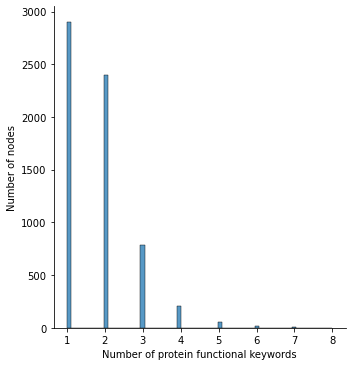

In [23]:
sns.displot(list(number_of_keywords.values()))
# add x axis label
plt.xlabel("Number of protein functional keywords")
# add y axis label
plt.ylabel("Number of nodes")

From those above, we want to reduce the number of keywords. Let's see how many keywords are amongst those with just 1 keyword:

In [24]:
# get all the protein IDs
single_keyword = {key for key, val in number_of_keywords.items() if val == 1}

In [25]:
# and then the corresponding keywords to those proteins
kws = set()
for key, val in nodes2keywords.items():
    if key in single_keyword:
        kws.update(val)

In [26]:
# now subet nodes2keywords to include only those proteins with a single keyword
nodes2keywords = {key: val.intersection(kws) for key, val in nodes2keywords.items() if len(val.intersection(kws)) > 0}

In [27]:
len(nodes2keywords)

6378

How much of the proteins in the KG does that cover?

In [28]:
len(nodes2keywords) / len(proteins_in_kg)

0.68573271691216

In [29]:
len(kws)

28

We'll cut these down a bit more to start small:

In [30]:
keep_kws = {'Chaperone',
            'Chromatin regulator',
            'Cytokine',
            'DNA-binding',
            'Developmental protein',
            'Growth factor',
            'Hydrolase',
            'Ion channel',
            'Oxidoreductase',
            'RNA-binding',
            'Receptor',
            'Repressor',
            'Ribonucleoprotein',
            'Transferase'}

Okay, how many do we have left?

In [31]:
# now subet nodes2keywords to include only those proteins with a single keyword
nodes2keywords = {key: val.intersection(keep_kws) for key, val in nodes2keywords.items() if len(val.intersection(keep_kws)) > 0}

In [32]:
len(nodes2keywords) / len(proteins_in_kg)

0.6044511342866359

We still have 60% left, so that's good!

In [33]:
len(keep_kws)

14

So if we narrow it down to these 14 classes, we still include all the proteins we had before.

In [34]:
# get most_popular for only terms for kws
keyword_freqs = {key: val for key, val in most_popular.items() if key in keep_kws}
keyword_freqs

{'RNA-binding': 387,
 'DNA-binding': 1071,
 'Repressor': 341,
 'Hydrolase': 948,
 'Transferase': 1190,
 'Ion channel': 234,
 'Receptor': 1188,
 'Developmental protein': 498,
 'Chromatin regulator': 170,
 'Cytokine': 167,
 'Oxidoreductase': 393,
 'Chaperone': 107,
 'Growth factor': 109,
 'Ribonucleoprotein': 206}

Okay, let's get a dictionary mapping proteins in the KG to their class. If they don't map to anything, map them to a generic protein class ('Gene', to keep it consistent with the KG).

In [35]:
node2class = dict()

for node in proteins_in_kg:
    if node in nodes2keywords:
        node2class[node] = list(nodes2keywords[node])
    else:
        node2class[node] = ['Gene']

In [36]:
len(node2class) == len(proteins_in_kg)

True

In [37]:
# write dictionary to json file in MAPPING_DIR
with open(osp.join(MAPPING_DIR, 'node2class.json'), 'w') as f:
    json.dump(node2class, f, indent=4)

## Alter the KG:

Now, we want to alter the KG so that we replace rows with the interactions from those limited classes.

In [38]:
kg.head()

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Gene,upregulates
1,pubchem.compound:10607,Compound,ncbigene:203068,Gene,downregulates
2,pubchem.compound:10607,Compound,ncbigene:54658,Gene,downregulates
3,pubchem.compound:10607,Compound,ncbigene:7153,Gene,downregulates
4,pubchem.compound:10607,Compound,ncbigene:7277,Gene,downregulates


Change the protein classes:

In [39]:
# duplicate the df called kg
kg_subclass = pd.DataFrame(columns=kg.columns)

In [40]:
for i, row in tqdm(kg.iterrows()):
    # if both match:
    if row['source'] in node2class and row['target'] in node2class:
        for combo in list(it.product(node2class[row['source']], node2class[row['target']])):
            s_kw, t_kw = combo
            kg.loc[i, 'source_node_type'] = s_kw
            kg.loc[i, 'target_node_type'] = t_kw
            kg_subclass = kg_subclass.append(row, ignore_index=True)

    elif row['source'] in node2class:
        for kw in node2class[row['source']]:
            kg.loc[i, 'source_node_type'] = kw
            kg_subclass = kg_subclass.append(row, ignore_index=True)

    elif row['target'] in node2class:
        for kw in node2class[row['target']]:
            kg.loc[i, 'target_node_type'] = kw
            kg_subclass = kg_subclass.append(row, ignore_index=True)
    else:
        kg_subclass = kg_subclass.append(row, ignore_index=True)

96569it [13:22, 120.40it/s]


In [41]:
kg_subclass

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Cytokine,upregulates
1,pubchem.compound:10607,Compound,ncbigene:203068,Gene,downregulates
2,pubchem.compound:10607,Compound,ncbigene:54658,Transferase,downregulates
3,pubchem.compound:10607,Compound,ncbigene:7153,DNA-binding,downregulates
4,pubchem.compound:10607,Compound,ncbigene:7277,Hydrolase,downregulates
...,...,...,...,...,...
131017,ncbigene:4157,Receptor,GO:0042438,Biological Process,participates
131018,pubchem.compound:16197727,Compound,ncbigene:4157,Receptor,upregulates
131019,ncbigene:4157,Receptor,GO:0009650,Biological Process,participates
131020,ncbigene:64816,Oxidoreductase,GO:0019068,Biological Process,participates


In [44]:
kg_subclass['source_node_type'].value_counts()

Gene                     37304
DNA-binding              17431
Transferase              17124
Receptor                 12788
Developmental protein    10053
Hydrolase                 6670
Compound                  6276
Cytokine                  5252
Growth factor             4560
Repressor                 4532
RNA-binding               3084
Chromatin regulator       1849
Ribonucleoprotein         1676
Ion channel               1147
Oxidoreductase             822
Chaperone                  454
Name: source_node_type, dtype: int64

In [43]:
kg_subclass.to_csv(osp.join(KG_DIR, 'final_kg_subclassed.tsv'), sep='\t', index=False)